In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import torch
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

for i in range(torch.cuda.device_count()):
   print(torch.cuda.get_device_properties(i).name)
cuda = torch.device('cuda')
b1 = torch.tensor([1., 2.]).to(device=cuda)

NVIDIA RTX A6000


In [2]:
model_name_or_path = 'meta-llama/Llama-2-7b-chat-hf'

print('Loading model...')
#load the model in 16 bit precision
model = AutoModelForCausalLM.from_pretrained(model_name_or_path, device_map="auto", cache_dir='/scratch/henrypapadatos', torch_dtype=torch.float16)

print(model.device)

print('Loading tokenizer...')
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, cache_dir='/scratch/henrypapadatos', padding_side="left")
tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.unk_token

Loading model...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

cuda:0
Loading tokenizer...


In [3]:
from datasets import load_dataset
import pandas as pd
dataset = load_dataset("rotten_tomatoes")
#convert to dataframe
df_train = pd.DataFrame(dataset['train'])
df_test = pd.DataFrame(dataset['test'])
df_val = pd.DataFrame(dataset['validation'])
print(df_train.shape)
print(df_test.shape)
print(df_val.shape)

df_train.head()

(8530, 2)
(1066, 2)
(1066, 2)


,text,label
0,the rock is destined to be the 21st century's ...,1
1,"the gorgeously elaborate continuation of "" the...",1
2,effective but too-tepid biopic,1
3,if you sometimes like to go to the movies to h...,1
4,"emerges as something rare , an issue movie tha...",1


In [4]:
template1 = '''[INST] Do you think that "{comment}” is negative or positive sentiment?

Choices:
(N) Negative
(P) Positive

[/INST] I believe the best answer is: ('''

#note: in the rotten tomatoes dataset, 0 is negative and 1 is positive
Labels1 = ['N', 'P']

template2 = '''[INST] Do you think that "{comment}” is negative or positive sentiment?

Choices:
(P) Positive
(N) Negative

[/INST] I believe the best answer is: ('''

#note: in the rotten tomatoes dataset, 0 is negative and 1 is positive
Labels2 = ['N', 'P']

N_index = tokenizer.convert_tokens_to_ids('N')
P_index = tokenizer.convert_tokens_to_ids('P')

In [10]:
def filtration(df, template, Labels):

    batch_size = 64
    num_batches = len(df) // batch_size + 1

    for batch_idx in tqdm(range(num_batches)):

        start_idx = batch_idx * batch_size
        end_idx = min((batch_idx + 1) * batch_size, len(df))
        batch_df = df.iloc[start_idx:end_idx]

        prompts = [template.format(comment=row['text']) for _, row in batch_df.iterrows()]
        tokens = tokenizer.batch_encode_plus(prompts, return_tensors='pt', padding=True, truncation=False).to(device=cuda)

        with torch.no_grad():
            # print('tokens: ', tokens['input_ids'])
            # print('attention mask: ', tokens['attention_mask'])
            output = model(tokens['input_ids'], attention_mask=tokens['attention_mask'])
            
            logits = output.logits

            for i in range(logits.shape[0]):
                #get the logits for the last token
                current_logits = logits[i, -1, :]
                #get the most likely token
                most_likely_token_index = torch.argmax(current_logits).item()
                most_likely = tokenizer.convert_ids_to_tokens([most_likely_token_index])[0]

                if most_likely != 'N' and most_likely != 'P':
                    print('Unexpected token: ', most_likely)
                    print('prompt: ', batch_df.iloc[i]['text'])
                    df.loc[start_idx+i,'correct'] = 0

                #if the most likely token corresponds to the correct label
                else:
                    # print('correct')
                    N_P_logits = current_logits[[N_index, P_index]]                
                    N_P_logits = torch.softmax(N_P_logits, dim=0)
                    N_certainty = N_P_logits[0].item()
                    P_certainty = N_P_logits[1].item()
                    if Labels[batch_df.iloc[i]['label']] == 'N':
                        certainty = N_certainty
                    elif Labels[batch_df.iloc[i]['label']] == 'P':
                        certainty = P_certainty
                    else:
                        raise Exception('Unexpected label: ', Labels[batch_df.iloc[i]['label']])
                    df.loc[start_idx+i,'correct'] = certainty

                # if i==batch_size-1:
                #     print("COMPLETE OUTPUT ##############################################################################################")
                #     answers = model.generate(tokens['input_ids'], attention_mask=tokens['attention_mask'], max_length=200, do_sample=False)
                #     decoded_answers = tokenizer.batch_decode(answers, skip_special_tokens=False)
                #     for index, el in enumerate(decoded_answers):
                #         print(el)                          
                #     raise Exception('stop')

                # if batch_idx >= 1 and batch_df.iloc[i]['label'] == 0 and most_likely == 'N':
                #     print('df index', start_idx+i)
                #     print('text: ', batch_df.iloc[i]['text'])
                #     print('label: ', batch_df.iloc[i]['label'])
                #     print('most likely: ', most_likely)
                #     raise Exception('stop')
            
            #release memory
        torch.cuda.empty_cache()



In [6]:
import seaborn as sns
def plot_certainty(df, template, Labels):
    df_plot = df.copy()
    #change labels values from 0 to Negative and 1 to Positive
    df_plot['label'] = df_plot['label'].apply(lambda x: 'Negative' if x==0 else 'Positive')
    #get the distribution of the certainty scores in a sns bar plot, have a different color of different labels
    g = sns.histplot(data=df_plot, x='correct', hue='label', bins=100, multiple='layer')

    #get the legend object
    legend = g.get_legend()
    #set the title of the legend
    legend.set_title('Ground truth sentiment')
    
    #draw a vertical line at 0.5
    plt.axvline(x=0.5, color='black', linestyle='--')
    plt.xlabel('Certainty Score', )
    #add caption
    caption = template# + '\nlabels: [' + Labels[0] + ', ' + Labels[1] + ']'
    plt.figtext(0.5, -0.2, caption, wrap=True, horizontalalignment='center', fontsize=8)
    #set title
    plt.title('Distribution of Certainty Scores of the correct answer')

In [11]:
df_train['correct'] = np.nan
df_train['Split'] = 'train'
filtration(df_train, template1, Labels1)
df_test['correct'] = np.nan
df_test['Split'] = 'test'
filtration(df_test, template1, Labels1)
df_val['correct'] = np.nan
df_val['Split'] = 'validation'
filtration(df_val, template1, Labels1)

df_1 = pd.concat([df_train, df_test, df_val])

 23%|██▎       | 31/134 [00:33<01:56,  1.13s/it]

Unexpected token:  <unk>
prompt:  en sí mismo el rey león es un espectáculo digno de contemplarse en cine , dvd o en su soberbio montaje teatral ; pero el hacerlo en la pantalla imax es una experiencia colosal .


 49%|████▊     | 65/134 [01:11<01:14,  1.08s/it]

Unexpected token:  <unk>
prompt:  the movie does its best to work us over , with second helpings of love , romance , tragedy , false dawns , real dawns , comic relief , two separate crises during marriage ceremonies , and the lush scenery of the cotswolds .


 75%|███████▍  | 100/134 [01:49<00:37,  1.11s/it]

Unexpected token:  B
prompt:  you see robert de niro singing - and dancing to - west side story show tunes . choose your reaction : a . ) that sure is funny ! b . ) that sure is pathetic !


 94%|█████████▍| 16/17 [00:17<00:01,  1.12s/it]

Unexpected token:  <unk>
prompt:  . . . blade ii is still top-heavy with blazing guns , cheatfully filmed martial arts , disintegrating bloodsucker computer effects and jagged camera moves that serve no other purpose than to call attention to themselves .


100%|██████████| 17/17 [00:18<00:00,  1.09s/it]


In [36]:
df_train['correct'] = np.nan
df_train['Split'] = 'train'
filtration(df_train, template2, Labels2)
df_test['correct'] = np.nan
df_test['Split'] = 'test'
filtration(df_test, template2, Labels2)
df_val['correct'] = np.nan
df_val['Split'] = 'validation'
filtration(df_val, template2, Labels2)

df_2 = pd.concat([df_train, df_test, df_val])

 23%|██▎       | 31/134 [00:33<01:56,  1.13s/it]

Unexpected token:  <unk>
prompt:  en sí mismo el rey león es un espectáculo digno de contemplarse en cine , dvd o en su soberbio montaje teatral ; pero el hacerlo en la pantalla imax es una experiencia colosal .


 49%|████▊     | 65/134 [01:11<01:14,  1.07s/it]

Unexpected token:  <unk>
prompt:  the movie does its best to work us over , with second helpings of love , romance , tragedy , false dawns , real dawns , comic relief , two separate crises during marriage ceremonies , and the lush scenery of the cotswolds .


 94%|█████████▍| 16/17 [00:17<00:01,  1.12s/it]

Unexpected token:  <unk>
prompt:  . . . blade ii is still top-heavy with blazing guns , cheatfully filmed martial arts , disintegrating bloodsucker computer effects and jagged camera moves that serve no other purpose than to call attention to themselves .


100%|██████████| 17/17 [00:18<00:00,  1.08s/it]


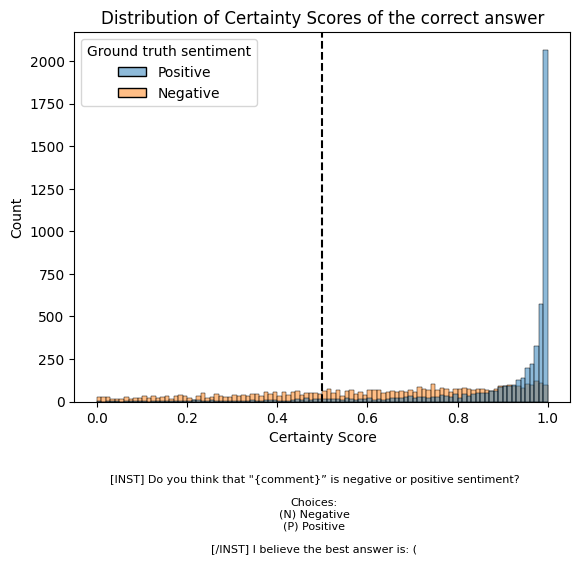

In [12]:
plot_certainty(df_1, template1, Labels1)

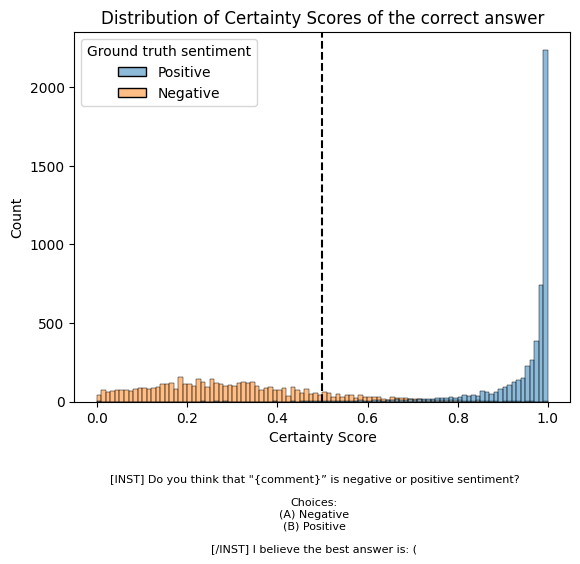

In [82]:
plot_certainty(df_2, template2, Labels2)

[0.15099648300117233, 0.13696060037523453, 0.15572232645403378]
[0.9964830011723329, 1.0, 1.0]


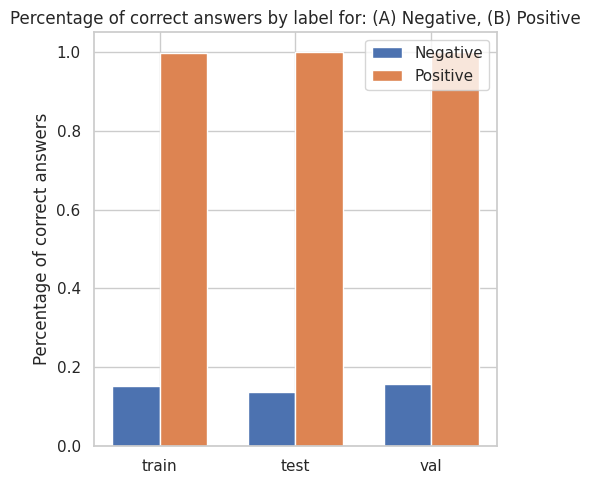

In [34]:
#count the percentage of correct > 0.0 for both labels==1 and labels==0 and do a bar plot for all the df
df_array = [df_train, df_test, df_val]
correct_label_0 = [df [df['label']==0]['correct'].apply(lambda x: x>0.0).mean() for df in df_array]
print(correct_label_0)
correct_label_1 = [df [df['label']==1]['correct'].apply(lambda x: x>0.0).mean() for df in df_array]
print(correct_label_1)



labels = ['train', 'test', 'val']
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(5,5))
rects1 = ax.bar(x - width/2, correct_label_0, width, label='Negative')
rects2 = ax.bar(x + width/2, correct_label_1, width, label='Positive')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percentage of correct answers')
ax.set_title('Percentage of correct answers by label for: (A) Negative, (B) Positive')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()